# Set-up

Mount Google Drive so we have access to the dataset, the files defining our model, and so that we can save the results of training.

In [ ]:
# Importing necessary module to mount Google Drive
from google.colab import drive

# Mounting Google Drive to access files
drive.mount('/content/drive')

# Importing sys module
import sys

# Defining the foldername for Weights and Biases project
foldername = '/WandB/week_1/'

# Appending the path to the project folder in Google Drive
sys.path.append(f'/content/drive/My Drive/{foldername}')

# Changing the current directory to the project folder in Google Drive
%cd /content/drive/My\ Drive/$foldername

Mounted at /content/drive
/content/drive/My Drive/WandB/assignment_1


Install depedencies that were used for training the Huggingface transformer model on the Kaggle Goodreads dataset.

In [ ]:
# Install required packages
!pip3 install wandb transformers[sentencepiece] datasets evaluate 

# Import necessary modules
import wandb, transformers, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that plots are displayed inline
%matplotlib inline

# Check if CUDA is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Enable autoreload for code changes
%load_ext autoreload
%autoreload 2

# Import functions for loading datasets and metrics from Hugging Face
from datasets import load_from_disk, load_dataset, Dataset, load_metric

# Import required classes and functions from the Transformers library
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

# Import the evaluate module
import evaluate

# Import the EarlyStoppingCallback and TrainerCallback from transformers
from transformers.trainer_callback import (EarlyStoppingCallback, 
                                           TrainerCallback)

# Import the params module
import params

# Import notebook_login function from huggingface_hub
from huggingface_hub import notebook_login

# Log in to the Hugging Face Hub
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# EDA

## Log raw data

In [ ]:
# Start wandb run for downloading raw data.
run = wandb.init(project=params.WANDB_PROJECT,
                 entity=None,
                 job_type=params.RAW_DATA_JOB_TYPE,
                 name='raw_data_2')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Define the path to the training data CSV file
train_path = '/content/drive/My Drive/WandB/assignment_1/data/raw_data/goodreads_train.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(train_path)  

# Create a new Weights and Biases (WandB) Artifact for the raw data
raw_data_art = wandb.Artifact(params.RAW_DATA_ARTIFACT, type=params.DATASET_TYPE)

# Add the CSV file to the Artifact
raw_data_art.add_file('./data/raw_data/goodreads_train.csv')

# Log the Artifact in the current WandB run
run.log_artifact(raw_data_art)

# Finish the current WandB run
run.finish()

## Downsample and Tokenize

In [ ]:
# Initialize a WandB run with specified project, entity, job type, and name
run = wandb.init(project=params.WANDB_PROJECT,
                 entity=None,
                 job_type=params.PROCESSED_DATA_ARTIFACT,
                 name='processed_data')

# Use the latest version of the raw data artifact
raw_data_at = run.use_artifact(f'{params.RAW_DATA_ARTIFACT}:latest')

# Check if the DataFrame 'df' is empty
if df.empty:
    # If 'df' is empty, download the raw data
    path = raw_data_at.download()
    # Load the downloaded data into the DataFrame 'df'
    df = pd.read_csv(path + '/goodreads_train.csv')

wandb: Currently logged in as: dmeltzer. Use `wandb login --relogin` to force relogin


Let's next count the number of reviews of a given rating.

In [ ]:
df.rating.value_counts()

4    313688
5    265007
3    188972
2     72627
0     30988
1     28718
Name: rating, dtype: int64

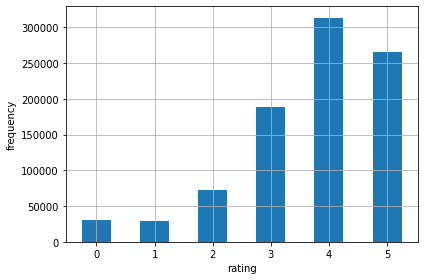

<Figure size 432x288 with 0 Axes>

In [ ]:
# Create a histogram of the 'rating' column in the DataFrame 'df'
hist_plot = df['rating'].hist(bins=np.arange(7)-.5, rwidth=.5)

# Add labels to the x and y axes
plt.xlabel('rating')
plt.ylabel('frequency')

# Adjust the layout for better visualization
plt.tight_layout()

# Display the histogram plot
plt.show()

# Save the figure as 'Rating_Frequencies' (Note: This should be before showing or logging the plot)
plt.savefig('Rating_Frequencies')

# Log the histogram plot to WandB under the key "Rating Frequencies"
wandb.log({"Rating Frequencies": hist_plot})

Below we print the total number of reviews (90k), the number of unique books(25k) and the unique number of user (12k).

In [ ]:
print(df.shape)
print(df.book_id.nunique())
print(df.user_id.nunique())

(900000, 11)
25474
12188


In [ ]:
# Convert the 'review_text' column to lowercase for consistent text processing
df['review_text'] = df.loc[:, 'review_text'].map(lambda x: x.lower())

# Remove extra whitespaces and join words together for better text processing
df['review_text'] = df.loc[:, 'review_text'].map(lambda x: ' '.join(x.split()).strip())

# Find the 100 most common reviews and create a DataFrame with 'Frequency' and 'review_text' columns
common_reviews = pd.DataFrame(df['review_text'].value_counts()[:100]).reset_index().rename(columns={'review_text': 'Frequency', 'index': 'review_text'})

# Log the common reviews as a wandb.Table with the key 'Common Reviews'
wandb.log({'Common Reviews': wandb.Table(dataframe=common_reviews)})

# Print the size of the training set before and after removing duplicate reviews
print(f'Size of training set before removal of duplicate reviews: {len(df)}')
df.drop_duplicates(subset=['review_text'], inplace=True, keep='first')
print(f'Size of training set after removal of duplicate reviews: {len(df)}')

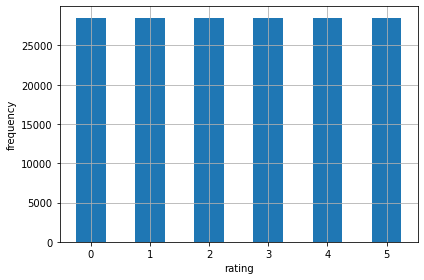

In [ ]:
# Import necessary modules for undersampling
import imblearn
from imblearn.under_sampling import RandomUnderSampler

# Initialize a RandomUnderSampler with a specified random state
undersample = RandomUnderSampler(random_state=42)

# Perform undersampling to balance the classes, returning a downsampled DataFrame and balanced labels
df, y_bal = undersample.fit_resample(df.drop(columns=['rating']), df['rating'])

# Update the 'rating' column with the balanced labels
df['rating'] = y_bal

# Delete the variable holding balanced labels to free up memory
del y_bal

# Generate a random permutation of the DataFrame indices
random_perm = np.random.permutation(len(df))

# Apply the permutation to shuffle the DataFrame
df = df.iloc[random_perm]

# Reset the DataFrame index after shuffling
df.reset_index(inplace=True)

# Drop the old index column
df.drop(columns='index', inplace=True)

# Create a histogram of the downsampled ratings for visualization
hist_plot_downsampled = df['rating'].hist(bins=np.arange(7)-.5, rwidth=.5)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

# Log the histogram as 'Frequency of Ratings After Downsampling' in the wandb project
wandb.log({'Frequency of Ratings After Downsampling': hist_plot_downsampled})

Count the number of unique books (23k) and user ids (11k) after undersampling. 

In [ ]:
print(df.book_id.nunique())
print(df.user_id.nunique())
print(len(df))

23410
11164
171312


In [ ]:
# Calculate the length of each review and create a new column 'full_length' to store the results
df['full_length'] = df['review_text'].map(lambda x: len(x))

# Calculate the mean word length in each review and create a new column 'mean_word_length' to store the results
df['mean_word_length'] = df['review_text'].map(lambda x: np.mean(list(map(len, x.split()))))

# Create a new wandb Artifact for the processed data
processed_data_art = wandb.Artifact(params.PROCESSED_DATA_ARTIFACT, type=params.DATASET_TYPE)

# Add the directory containing the processed data to the Artifact
processed_data_art.add_dir(params.PROCESSED_DATA_FOLDER)

# Log the processed data Artifact to the wandb run
run.log_artifact(processed_data_art)

# Finish the wandb run
run.finish()

wandb: Adding directory to artifact (./data/processed_data)... Done. 7.8s


## Splitting Data

In [ ]:
# Start a new wandb run for splitting data.

run = wandb.init(project=params.WANDB_PROJECT, job_type=params.SPLIT_DATA_JOB_TYPE,name='split_data')
run.use_artifact(f'{params.PROCESSED_DATA_ARTIFACT}:latest')

<Artifact QXJ0aWZhY3Q6MzU4MTU5NDM4>

In [ ]:
# Initialize GroupShuffleSplit for train/test split with 80% for training
# and 20% for testing, using a specific random seed for reproducibility
gs_test = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)

# Initialize GroupShuffleSplit for train/validation split with 75% for training
# and 25% for validation, using a specific random seed for reproducibility
gs_valid = GroupShuffleSplit(n_splits=2, train_size=.75, random_state=43)

# Generate train and test indices for the data
train_idx, test_idx = next(iter(gs_test.split(df, groups=df.book_id)))

# Create a new DataFrame for training data using the generated indices
train_df = df.loc[train_idx].reset_index(drop=True)

# Create a new DataFrame for test data using the generated indices
test_df = df.loc[test_idx].reset_index(drop=True)

# Generate train and validation indices for the training data
train_idx, valid_idx = next(iter(gs_valid.split(train_df, groups=train_df.book_id)))

# Create a new DataFrame for validation data using the generated indices
valid_df = train_df.loc[valid_idx]

# Modify the existing train DataFrame to exclude validation samples
train_df = train_df.loc[train_idx]

# Reset indices for all DataFrames to maintain consistency
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
# Calculate the proportion of data allocated for training by dividing the length of the training set
# by the total length of the original dataset.
train_proportion = len(train_df) / len(df)

# Print the proportion of data allocated for training.
print(train_proportion)

# Calculate the proportion of data allocated for testing by dividing the length of the test set
# by the total length of the original dataset.
test_proportion = len(test_df) / len(df)

# Print the proportion of data allocated for testing.
print(test_proportion)

# Calculate the proportion of data allocated for validation by dividing the length of the validation set
# by the total length of the original dataset.
valid_proportion = len(valid_df) / len(df)

# Print the proportion of data allocated for validation.
print(valid_proportion)


0.5899586718968899
0.2054964042215373
0.2045449238815728


In [ ]:
# Initialize a tokenizer using the specified pretrained model name.
tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)

def tokenize_batch(batch):
    """
    Tokenizes a batch of input text.

    Parameters:
    -----------
        batch (dict): A dictionary containing the input text to be tokenized.

    Returns:
    --------
        tokenized_batch (dict): A dictionary containing the tokenized inputs.

    """
    # Tokenize the input batch, adding padding and truncation as specified.
    tokenized_batch = tokenizer(batch['review_text'], padding=True, truncation=True)
    return tokenized_batch

In [ ]:
# Create datasets from the pandas DataFrames.
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(valid_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize the datasets using the specified batch tokenization function.
train_dataset = train_dataset.map(tokenize_batch, batched=True)
valid_dataset = valid_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

  0%|          | 0/102 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/36 [00:00<?, ?ba/s]

In [ ]:
# Save the datasets to disk in the specified directories.
train_dataset.save_to_disk(params.TRAIN_DATA_FOLDER)
valid_dataset.save_to_disk(params.VALID_DATA_FOLDER)
test_dataset.save_to_disk(params.TEST_DATA_FOLDER)

# Create WandB Artifacts for the train, valid, and test datasets.
train_data_art = wandb.Artifact(params.TRAIN_DATA_ARTIFACT, type=params.DATASET_TYPE)
valid_data_art = wandb.Artifact(params.VALID_DATA_ARTIFACT, type=params.DATASET_TYPE)
test_data_art = wandb.Artifact(params.TEST_DATA_ARTIFACT, type=params.DATASET_TYPE)

# Add the directories containing the datasets to the respective artifacts.
train_data_art.add_dir(params.TRAIN_DATA_FOLDER)
valid_data_art.add_dir(params.VALID_DATA_FOLDER)
test_data_art.add_dir(params.TEST_DATA_FOLDER)

# Log the artifacts in the run.
run.log_artifact(train_data_art)
run.log_artifact(valid_data_art)
run.log_artifact(test_data_art)

# Finish the run.
run.finish()


# Baseline Model

In this section we will train two models, DistilBERT and BERT-tiny and measure how they do on the classifying the Goodreads dataset.

## Distilbert

In [ ]:
run = wandb.init(project=params.WANDB_PROJECT, job_type=params.MODEL_TRAINING_JOB_TYPE,name='baseline_training_batch')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Load train and validation datasets from disk.
train_dataset = load_from_disk('./data/train_data')
valid_dataset = load_from_disk('./data/valid_data')

# Initialize a tokenizer for tokenizing the text.
tokenizer = AutoTokenizer.from_pretrained(params.MODEL_NAME)

# Define a function to tokenize a batch of text.
def tokenize_batch(batch):
    tokenized_batch = tokenizer(batch['review_text'], padding=True, truncation=True)
    return tokenized_batch

# Create a data collator for padding the tokenized inputs.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define a list of columns to drop from the datasets.
drop_cols = [col for col in list(train_dataset.features) if col not in ['input_ids', 'attention_mask', 'rating']]

# Remove the specified columns from the datasets.
train_dataset = train_dataset.remove_columns(drop_cols)
valid_dataset = valid_dataset.remove_columns(drop_cols)

# Rename the 'rating' column to 'labels' for compatibility with the model.
train_dataset = train_dataset.rename_column('rating', 'labels')
valid_dataset = valid_dataset.rename_column('rating', 'labels')

# Set the format of the datasets to use PyTorch tensors.
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize a model for sequence classification.
model = AutoModelForSequenceClassification.from_pretrained(params.MODEL_NAME, num_labels=params.NUM_CLASSES)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the specified device (e.g., GPU).
model.to(device)


In [ ]:
# Load evaluation metrics for accuracy, F1 score, recall, and precision.
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
recall_metric = evaluate.load('recall')
precision_metric = evaluate.load('precision')

# Define a function to compute evaluation metrics.
def compute_metrics(eval_pred):
    """
    Computes evaluation metrics.

    Args:
        eval_pred (tuple): Tuple containing logits and labels.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return acc_metric.compute(predictions=predictions, references=labels)

# Define training arguments for the Trainer.
training_args = TrainingArguments(
    output_dir=params.MODEL_DATA_FOLDER,
    num_train_epochs=3,
    per_device_train_batch_size=params.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=params.VALID_BATCH_SIZE,
    warmup_steps=params.WARMUP_STEPS,
    fp16=params.FP16,
    learning_rate=float(params.LEARNING_RATE),
    logging_dir=f"{params.MODEL_DATA_FOLDER}/logs",
    logging_steps=100,
    evaluation_strategy='steps',
    save_steps=2000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='wandb',
    push_to_hub=params.PUSH_TO_HUB,
    hub_strategy=params.HUB_STRATEGY,
    hub_model_id=params.HUB_MODEL_ID
)

# Initialize the Trainer for training the model.
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics
)

trainer.train()
trainer.save_model("./"+params.MODEL_DATA_FOLDER)
run.log({"Performance-data": wandb.Table(dataframe=pd.DataFrame(outputs, 
                                                                index=["Performance"]))})
model.push_to_hub(params.HUB_MODEL_ID)
tokenizer.push_to_hub(params.HUB_MODEL_ID)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
Cloning https://huggingface.co/dhmeltzer/distilbert-goodreads-wandb into local empty directory.
Using cuda_amp half precision backend


In [ ]:
# Import necessary module for interacting with the Hugging Face Model Hub.
from huggingface_hub import HfApi

# Create an instance of the Hugging Face API.
hf_api = HfApi()

# Retrieve information about the currently authenticated user.
user = hf_api.whoami()

# Create a Wandb Artifact for the trained model.
trained_model_art = wandb.Artifact(params.HUB_MODEL_ID, type=params.MODEL_TYPE)

# Construct the hub_id by combining the user's name and the model's identifier.
hub_id = f"{user['name']}/{params.HUB_MODEL_ID}"

# Add metadata to the Artifact, specifying the hub_id.
trained_model_art.metadata = {"hub_id": hub_id}

# Log the trained model Artifact.
run.log_artifact(trained_model_art)

# Finish the run.
run.finish()

eval/accuracy,▁▅▅▆▅▆▇▇▇▇▇▇▇▇▇█▇██▇█▇██████████████████
eval/loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁
eval/runtime,▁▂▃▃▃▂▂▂▃▃▃▃▃▃▄▃▄▄▄▄▄▄▄▅▃▅▅▅▅▅▆▅▆▆▄▅▅▅▅█
eval/samples_per_second,█▇▆▆▆▇▆▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▅▄▄▄▄▁
eval/steps_per_second,█▇▆▆▆▇▆▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▅▄▄▄▄▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,▁▃▃▆███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂
train/loss,█▇▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
train/total_flos,▁
train/train_loss,▁


## Bert Tiny

In [ ]:
run = wandb.init(project=params.WANDB_PROJECT, job_type=params.MODEL_TRAINING_JOB_TYPE,name='baseline_bert_tiny')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Load training and validation datasets from disk.
train_dataset = load_from_disk('./data/train_data')
valid_dataset = load_from_disk('./data/valid_data')

# Initialize the tokenizer using the 'prajjwal1/bert-tiny' model.
tokenizer = AutoTokenizer.from_pretrained('prajjwal1/bert-tiny')

def tokenize_batch(batch):
    """
    Tokenizes a batch of text data.

    Args:
        batch (dict): A dictionary containing the input text data.

    Returns:
        dict: Tokenized batch containing 'input_ids' and 'attention_mask'.
    """
    tokenized_batch = tokenizer(batch['review_text'], padding=True,
                                truncation=True)
    return tokenized_batch

# Initialize the data collator with padding.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Drop columns from the datasets that are not needed for processing.
drop_cols = [col for col in list(train_dataset.features) if col not in ['input_ids', 'attention_mask', 'rating']]
train_dataset = train_dataset.remove_columns(drop_cols)
valid_dataset = valid_dataset.remove_columns(drop_cols)

# Rename the 'rating' column to 'labels' for compatibility.
train_dataset = train_dataset.rename_column('rating', 'labels')
valid_dataset = valid_dataset.rename_column('rating', 'labels')

# Set the format of the datasets for PyTorch compatibility.
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
valid_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize the model for sequence classification using 'prajjwal1/bert-tiny'.
model = AutoModelForSequenceClassification.from_pretrained('prajjwal1/bert-tiny',
                                                           num_labels=params.NUM_CLASSES)

# Move the model to the specified device (e.g., 'cuda' or 'cpu').
model.to(device)

In [ ]:
# Load evaluation metrics
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')
recall_metric = evaluate.load('recall')
precision_metric = evaluate.load('precision')

def compute_metrics(eval_pred):
    """
    Computes evaluation metrics based on model predictions.

    Args:
        eval_pred (tuple): Tuple containing logits and labels.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return acc_metric.compute(predictions=predictions, references=labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='tinybert-goodreads-model',
    num_train_epochs=6,
    per_device_train_batch_size=params.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=params.VALID_BATCH_SIZE,
    warmup_steps=params.WARMUP_STEPS,
    fp16=params.FP16,
    learning_rate=float(params.LEARNING_RATE),
    logging_dir=f"tinybert-goodreads-model/logs",
    logging_steps=1000,
    evaluation_strategy='steps',
    save_steps=2000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='wandb'
    #,push_to_hub=params.PUSH_TO_HUB,
    #hub_strategy=params.HUB_STRATEGY,
    #hub_model_id=params.HUB_MODEL_ID
)

# Initialize the Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    #callbacks=[EarlyStoppingCallback()],
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
outputs = trainer.evaluate()

# Save the trained model
trainer.save_model("./tinybert-goodreads-model")

# Log performance metrics to WandB
run.log({"Performance-data": wandb.Table(dataframe=pd.DataFrame(outputs, index=["Performance"]))})

# Push the model and tokenizer to the Hugging Face Model Hub
model.push_to_hub('dhmeltzer/tinybert-goodreads-wandb')
tokenizer.push_to_hub('dhmeltzer/tinybert-goodreads-wandb')

using `logging_steps` to initialize `eval_steps` to 1000
PyTorch: setting up devices
Using cuda_amp half precision backend


In [ ]:
# Import necessary module
from huggingface_hub import HfApi

# Create an instance of HfApi
hf_api = HfApi()

# Get user information
user = hf_api.whoami()

# Create a WandB artifact for the trained model
trained_model_art = wandb.Artifact('tinybert-goodreads-wandb', type=params.MODEL_TYPE)

# Define the hub_id for the model
hub_id = f"{user['name']}/distilbert-goodreads-wandb"

# Add metadata to the artifact
trained_model_art.metadata = {"hub_id": hub_id}

# Log the artifact
run.log_artifact(trained_model_art)

# Finish the run
run.finish()

eval/accuracy,▁▂▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████▇▇██████
eval/loss,██▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▂▂▂▂▄▃▆▅▃▂▃▃▃▃
eval/runtime,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▅▁▂▁▁▁▁█
eval/samples_per_second,▅███████▇████████▇█▇████▇██▇████▄█▆████▁
eval/steps_per_second,▅███████▇████████▇█▇████▇██▇████▄█▆████▁
train/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▃▄▁▂▃▂▃▄▅▅▂▂▂▂▃▄▅▆▇█
train/global_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▁▂▃▄▁▂▁▂▃▄▅▅▂▃▂▃▄▅▅▇▇█
train/learning_rate,▂▅█████▇▇▇▇▇▇▇▇▇▆▆▆█▅▃▂▇▇█▇▆▅▄█▇█▇▆▅▄▃▂▁
train/loss,██▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▁▂▂▂▃▂▂▂
train/total_flos,▃▁▅▁█
train/train_loss,█▆▅▁▁


# Extra EDA

In this section we will continue to perform exploratory data analysis in order to get a better understanding of the dataset.

In [ ]:
import re
import string
import os
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, inaugural

from textblob import TextBlob

from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('stopwords')
from nltk.stem import PorterStemmer

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
run = wandb.init(project=params.WANDB_PROJECT,entity=None, job_type='validating_split')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
train_data_art=run.use_artifact(f'{params.TRAIN_DATA_ARTIFACT}:latest')
train_path=train_data_art.download()
train_dataset=load_from_disk(train_path)
df=pd.DataFrame(train_dataset)

wandb: Downloading large artifact goodreads_train_data:latest, 367.30MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:10.2


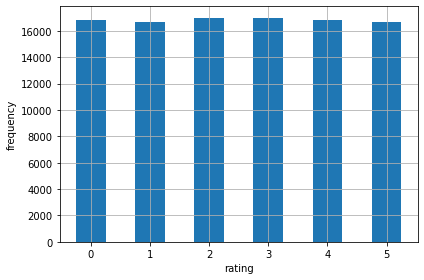

In [ ]:
hist_plot=df['rating'].hist(bins=np.arange(7)-.5,rwidth=.5)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
corr_plot=df[['rating','full_length','mean_word_length']].corr(method='spearman')
wandb.log({'Correlation Plot':corr_plot})
corr_plot

,rating,full_length,mean_word_length
rating,1.000000,0.177879,0.024761
full_length,0.177879,1.000000,0.094891
mean_word_length,0.024761,0.094891,1.000000


/usr/local/lib/python3.8/dist-packages/plotly/matplotlylib/renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



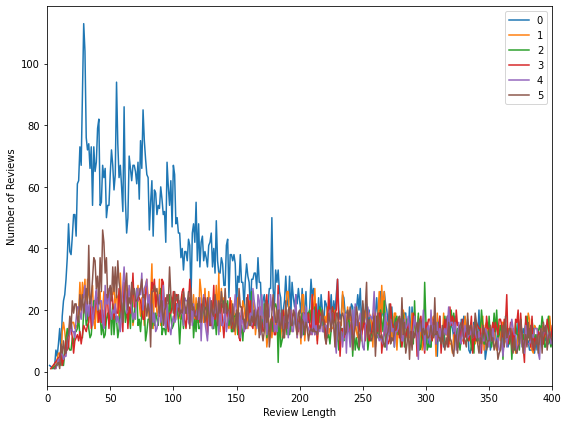

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

for label,DF in df.groupby('rating'):
    ax.plot(DF['full_length'].value_counts().sort_index(),label=str(label) )
ax.set_xlim([0,400])
plt.legend()
ax.set_xlabel('Review Length')
ax.set_ylabel('Number of Reviews')
plt.tight_layout()
wandb.log({'Number of Reviews vs Length':plt})
fig

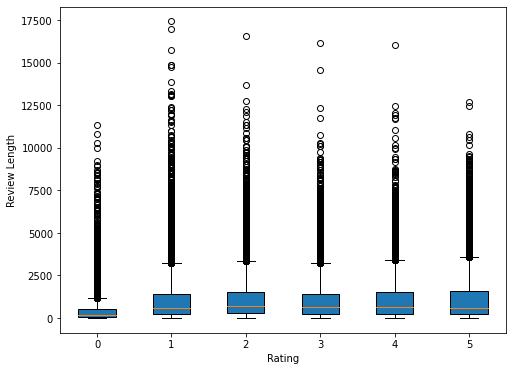

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
data=[]
for label,DF in df.groupby('rating'):
    data.append(list(DF['full_length'].values))
    plt.xlabel(label)
ax.boxplot(data,labels=[0,1,2,3,4,5],patch_artist=True)
#ax.boxplot(data,patch_artist=True)
ax.set_xlabel('Rating')
ax.set_ylabel('Review Length')
fig.show()
plt.savefig('box_plot_ratings')

In [ ]:
lem = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have",
                     "couldna": "could not have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

def clean_text(text):
    """
    Applies some pre-processing on the given text.
    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    - Tokenizing and lemmatizing sentence
    """

    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # remove the characters [\] and ["]
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\"", "", text)

    # remove all non-ASCII characters:
    text = re.sub(r'[^\x00-\x7f]', r'', text)

    # remove URL
    text = re.sub(r"http\S+", "", text)

    # replace punctuation characters with spaces
    filters = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = " ".join(text.split())
    return text

useless_words = nltk.corpus.stopwords.words("english") + list(string.punctuation)+['``',"''",'...','a',"--","***",'http',"**"]


def review_tokenize(text):
    stem=PorterStemmer()
    text=' '.join([w for w in text.split() if w not in useless_words])
    text="".join([stem.stem(w) for w in text])
    return text

def tokenize_filtered(text):
    x = re.sub(r'\d+', '', str(text))
    x = clean_text(x)
    x = expand_contractions(x)
    x = review_tokenize(x)
    #x = ' '.join(x)

    return x


In [ ]:
df['tok_review']=df['review_text'].map(lambda x:tokenize_filtered(x))
df['polarity'] = df['tok_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

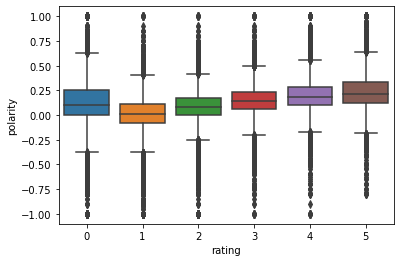

In [ ]:
sns.boxplot(data=df,y='polarity',x='rating')
plt.savefig('figures/sns_plot_new')

In [ ]:
counts=[]
for label, DF in df.groupby(by='book_id'):
    counts.append(len(DF))
plt.hist(sorted(counts,reverse=True),bins=20,range=[0,40])
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
wandb.log({'Frequency of Number of Reviews':plt})

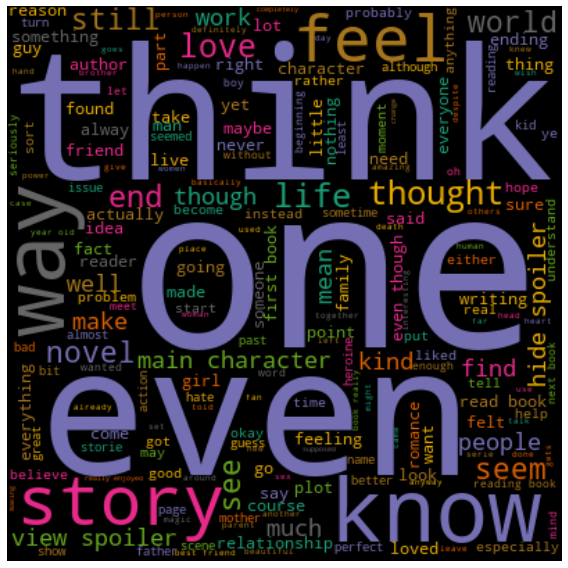

In [ ]:
r=' '.join(list(df["tok_review"].values))
wordcloud = WordCloud(width=400, height=400, max_words=200,colormap="Dark2").generate(r)  
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()

In [ ]:
corpus={}
for label, DF in df.groupby('rating'):
    corpus[label]=list(DF['tok_review'])

In [ ]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
#for i in range(0,1):
#    fig,ax=plt.subplots()
#
#    top_n_bigrams=get_top_ngram(corpus[i],1)[:20]
#    x,y=map(list,zip(*top_n_bigrams))
#    unigram_plot=ax.barh(x, y)
#    
#    ax.set_title(f'Top Unigrams at Rating = {i}')
#    ax.set_xlabel('frequency')
#    ax.set_ylabel(x)
#    ax.invert_yaxis()
#    ax.set_yticks(x)
#    plt.tight_layout()
#    #plt.savefig(f'./unigrams_rating_{i}')
#    #wandb.log({f'Unigrams at Rating {i}':plt})
#    plt.show()
    


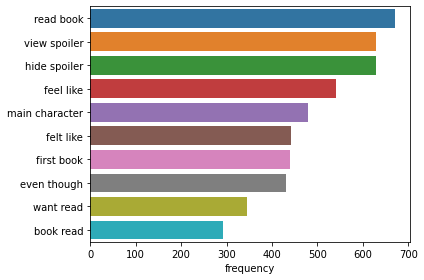

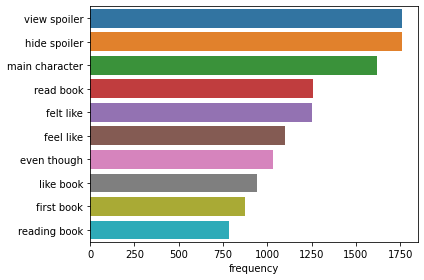

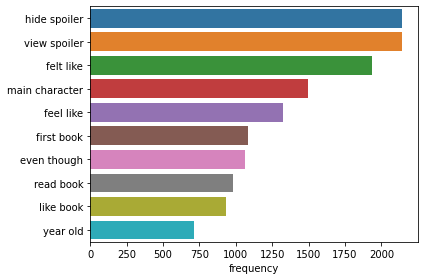

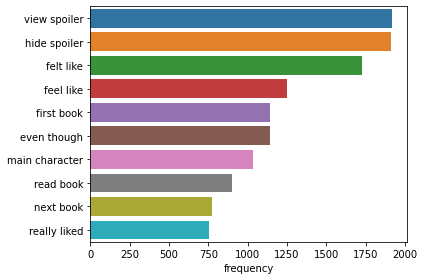

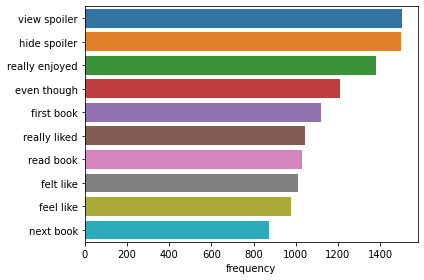

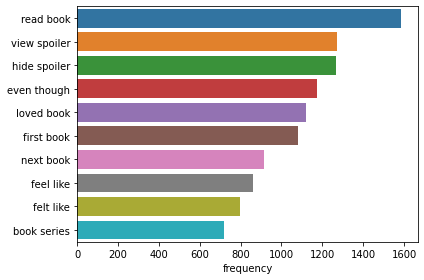

In [ ]:
for i in range(0,6):
    fig,ax=plt.subplots()

    top_n_bigrams=get_top_ngram(corpus[i],2)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    #ax.set_title(f'Top Bigrams at Rating = {i}')
    ax.set_xlabel('frequency')
    #ax.legend()
    plt.tight_layout()
    plt.savefig(f'./bigrams_rating_{i}')
    plt.show()
    #wandb.log({f'Bigrams at Rating {i}':plt})
    wandb.log({f'Bigrams at rating {i}':wandb.Image(f'./bigrams_rating_{i}.png')})

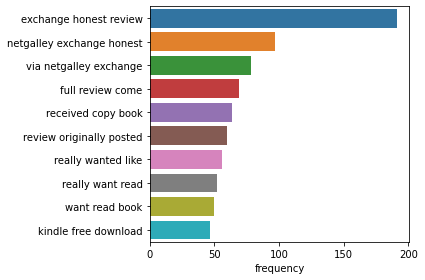

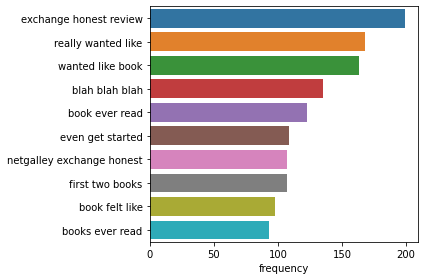

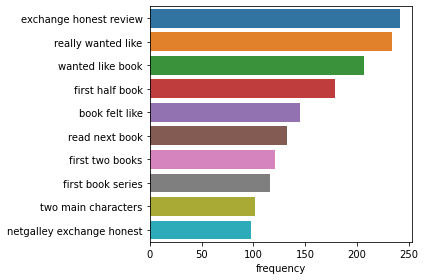

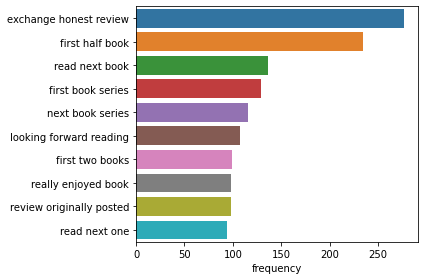

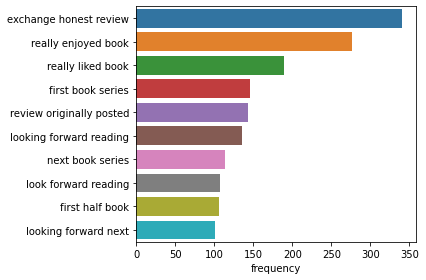

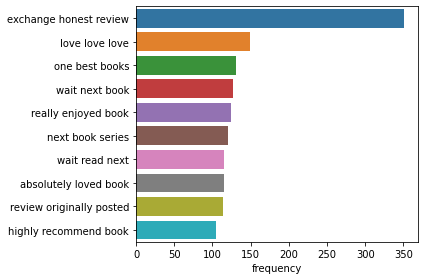

In [ ]:
for i in range(0,6):
    fig,ax=plt.subplots()

    top_n_trigrams=get_top_ngram(corpus[i],3)[:20]
    x,y=map(list,zip(*top_n_trigrams))
    sns.barplot(x=y,y=x)
    #ax.set_title(f'Top Bigrams at Rating = {i}')
    ax.set_xlabel('frequency')
    #ax.legend()
    plt.tight_layout()
    plt.savefig(f'./trigrams_rating_{i}')
    plt.show()
    #wandb.log({f'Bigrams at Rating {i}':plt})
    wandb.log({f'trigrams at rating {i}':wandb.Image(f'./trigrams_rating_{i}.png')})

In [ ]:
run.finish()

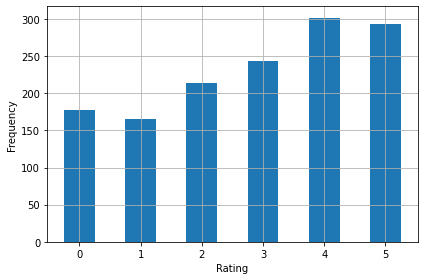

In [ ]:
honest_df=df[df['review_text'].map(lambda x:'in exchange for an honest review' in x)].rating
hist_plot_honest=honest_df.hist(bins=np.arange(7)-.5,rwidth=.5)
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.tight_layout()
plt.show()
wandb.log({"Appearance of 'exchange honest review'":hist_plot_honest})

In [ ]:
wandb.finish()

In [ ]:
import params

In [ ]:
run = wandb.init(project=params.WANDB_PROJECT,entity=None, job_type='validating_split')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
processed_data_art=run.use_artifact(f'{params.PROCESSED_DATA_ARTIFACT}:latest')
processed_path=processed_data_art.download()
processed_dataset=load_from_disk(processed_path)
df=pd.DataFrame(processed_dataset)

wandb: Downloading large artifact processed_data:latest, 619.67MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:5.9


In [ ]:
hist_plot=df['rating'].hist(bins=np.arange(7)-.5,rwidth=.5)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
df['user_id'].value_counts()

843a44e2499ba9362b47a089b0b0ce75    499
89792c2c139b39347004d2d8480046f6    479
aca760854b57ce2ec981df32e46dc96c    421
667b94d4c7e0b014bb6ab3636999e712    393
8e7e5b546a63cb9add8431ee6914cf59    345
                                   ... 
9c24473fbb6231eb5a2c6f5c2adae762      1
de43130afe391a2395c9704ab7ecd435      1
fed7fecf347eda6b7631dd2bd88c28c4      1
b1c563eb363711c400e4e678d968d1db      1
18d9b1e9858ee23f88d19e9b4ffb7bff      1
Name: user_id, Length: 11164, dtype: int64

In [ ]:
df['user_id'].value_counts().describe()

count    11164.000000
mean        15.345038
std         22.940507
min          1.000000
25%          3.000000
50%          8.000000
75%         19.000000
max        499.000000
Name: user_id, dtype: float64

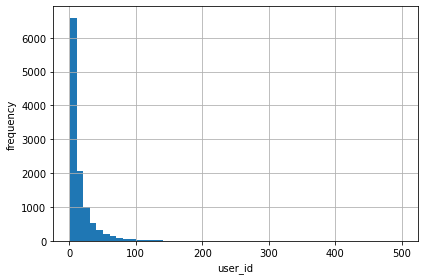

<Figure size 432x288 with 0 Axes>

In [ ]:
hist_plot=df['user_id'].value_counts().hist(bins=50)
plt.xlabel('user_id')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()
plt.savefig('user_id_frequencies')
wandb.log({"User ID Frequencies":hist_plot})

In [ ]:
user_id_vals=df['user_id'].value_counts()
print(len(user_id_vals[user_id_vals>=5]))
print(len(user_id_vals[user_id_vals<5]))

7362
3802


In [ ]:
user_ids_more_than_five=user_id_vals[user_id_vals>=5].index
user_ids_less_than_five=user_id_vals[user_id_vals<5].index

In [ ]:
df_more_than_five=df.loc[df['user_id'].isin(user_ids_more_than_five)]

In [ ]:
df_less_than_five=df.loc[df['user_id'].isin(user_ids_less_than_five)]

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

In [ ]:
sgkf = StratifiedGroupKFold(n_splits=5)

In [ ]:
groups=df_more_than_five['book_id'].to_numpy()
y=df_more_than_five['user_id'].to_numpy()

In [ ]:
train_idxs,test_idxs=next(iter(sgkf.split(np.arange(len(groups)), y, groups)))

In [ ]:
len(train_idxs)

129962

In [ ]:
df_less_than_five.head()

In [ ]:
X=np.arange(15)
y=[0,0,0,1,1,1,2,2,2,3,3,3,4,4,4]
groups=[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2]

sgkf = StratifiedGroupKFold(n_splits=4)
next(iter(sgkf.split(X, y, groups)))

ValueError: ignored

In [ ]:
train_path='/content/drive/My Drive/WandB/assignment_1/data/raw_data/goodreads_train.csv'
df=pd.read_csv(train_path)  

In [ ]:
user_review_counts=df['user_id'].value_counts()

In [ ]:
more_than_five=user_review_counts.loc[user_review_counts>=5].index

In [ ]:
more_than_five

Index(['aca760854b57ce2ec981df32e46dc96c', '843a44e2499ba9362b47a089b0b0ce75',
       '8e7e5b546a63cb9add8431ee6914cf59', '667b94d4c7e0b014bb6ab3636999e712',
       'aed35dbc626957174ebedf3c555b63d0', 'c0e0fda388f87af0deffad748c9c8b67',
       '422e76592e2717d5d59465d22d74d47c', 'ccf944f8aca6814c1ec21cad667b7123',
       '70bb4724bbc13a8d5ff0954b79c5d4ad', '1e4bc3467ddf378b3ca0c1399bcfdb1c',
       ...
       '8190d187fdda6a08a8408e58e5deeafa', 'ae45601158c4a59e9b7c182f52464a62',
       '446ab941d1010c40b2885e56124135ca', 'a99636e0fdc0e9a9838304932a035d58',
       '16d199f796cd8b8fa39a0222760e5973', '6da824eba6b486314d193f60f06ba8e8',
       'ba24bba464d6c286546b81fd9659e18a', '58fe4880f1c5746d7311867093747775',
       '18530c265612364070b557f04602841f', '973a6dd0d6f94e322b3a356047332c37'],
      dtype='object', length=11143)

In [ ]:
df_more_than_5=df.loc[df['user_id'].isin(more_than_five)]

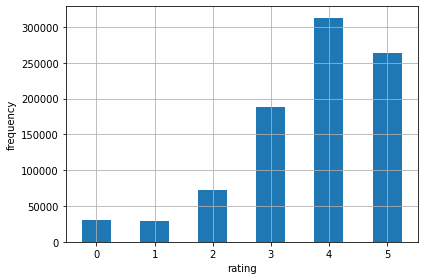

In [ ]:
hist_plot=df_more_than_5['rating'].hist(bins=np.arange(7)-.5,rwidth=.5)
plt.xlabel('rating')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

In [ ]:
df_more_than_5['rating'].value_counts()

4    312997
5    264078
3    188476
2     72354
0     30921
1     28543
Name: rating, dtype: int64

In [ ]:
len(df_more_than_5)

897369

In [ ]:
run.finish()